<a href="https://colab.research.google.com/github/Nayoung-young/prj-game-abtesting/blob/main/cookie_cats_abtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Base
# -----------------------------------
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('seaborn')
sns.set(font_scale = 1.5)

# import missingno as msno # null data를 쉽게 보여주는 라이브러리 

# import warnings 
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 
# 한 셀에서 그래프 보여주기 

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

<ipython-input-1-89e2dd236bad>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# _1. 데이터 불러오기 

In [2]:
df = pd.read_csv('cookie_cats.csv')
df_base = df.copy()

In [3]:
df_base.info() # 결측치 없음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df_base.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df_base['version'].unique().tolist()

['gate_30', 'gate_40']

In [6]:
df_base['userid'].nunique() # userid - unique 

90189

#_1. 프로젝트 설명 
- 출처: https://www.datacamp.com/projects/184 

[ 가설 ] 
`level 30에서 보여줄 때보다 level 40에서 구매유도를 할 경우 7일 리텐션이 더 높다 `
- 성공지표: retention_7 
- 보조지표: retention_1, max_gameround 

- Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment.
- It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level
- It also features singing cats. 

- As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 
- In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. 

**In particular, we will analyze the impact on player retention.**

# _2. 데이터 살펴보기 
- 결측치 없음 
- 중복데이터 없음 (userid 모두 고유값) 
- outlier 확인 필요 

In [7]:
df_base.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [8]:
df_base["sum_gamerounds"].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [9]:
df_base[['version', "sum_gamerounds"]].groupby(['version']).agg(["count", "median", "mean", "std", "max"])

sum_gamerounds                                     
                 count median       mean         std    max
version                                                    
gate_30          44700   17.0  52.456264  256.716423  49854
gate_40          45489   16.0  51.298776  103.294416   2640

In [10]:
# df = df.astype({'시가':'int'})

df_base = df_base.astype({'userid':'str'})
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 2.2+ MB


In [11]:
df_base.rename(columns={"sum_gamerounds": "max_gameround"}, inplace=True)

In [12]:
# gate에 따라 그룹 나누기 
df_30 = df_base[ df_base['version'] == 'gate_30' ]
df_40 = df_base[ df_base['version'] == 'gate_40' ]

## 2.1 Outlier 제거 전  

gamerounds - Before Removing The Extreme Value


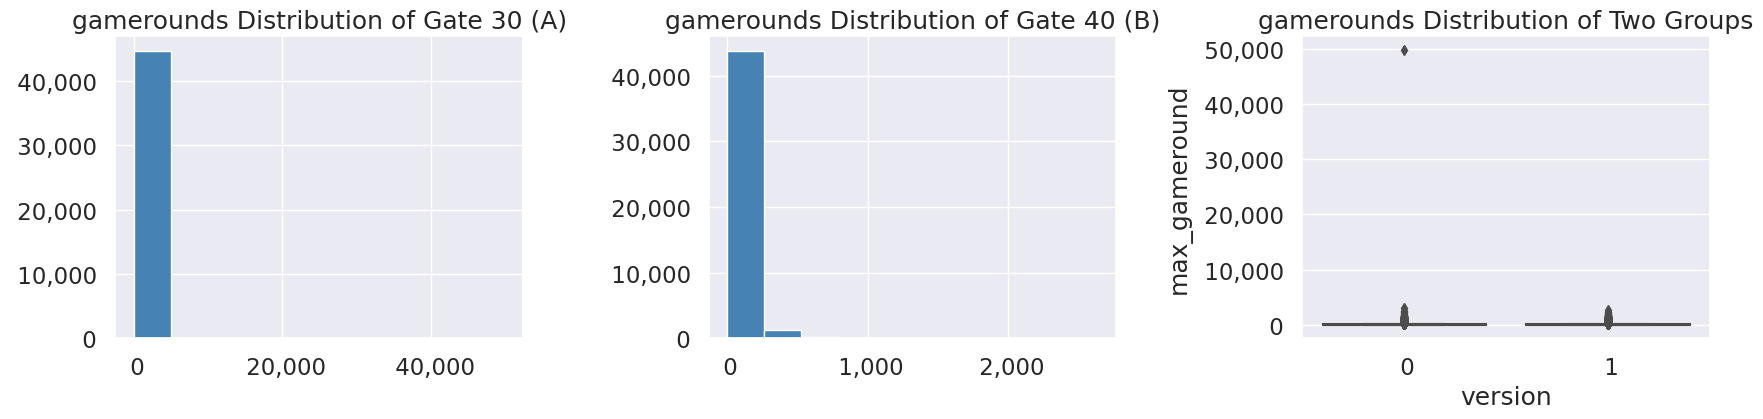

In [13]:
f, ax = plt.subplots(1, 3, figsize = (18,5))

df_30.hist("max_gameround", ax = ax[0], color = "steelblue")
df_40.hist("max_gameround", ax = ax[1], color = "steelblue")
sns.boxplot(x = df_base.version, y = df_base.max_gameround, ax = ax[2])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 


ax[0].set_title("gamerounds Distribution of Gate 30 (A)")
ax[1].set_title("gamerounds Distribution of Gate 40 (B)")
ax[2].set_title("gamerounds Distribution of Two Groups")

print("gamerounds - Before Removing The Extreme Value")
plt.tight_layout(pad = 2);

gamerounds - Before Removing The Extreme Value


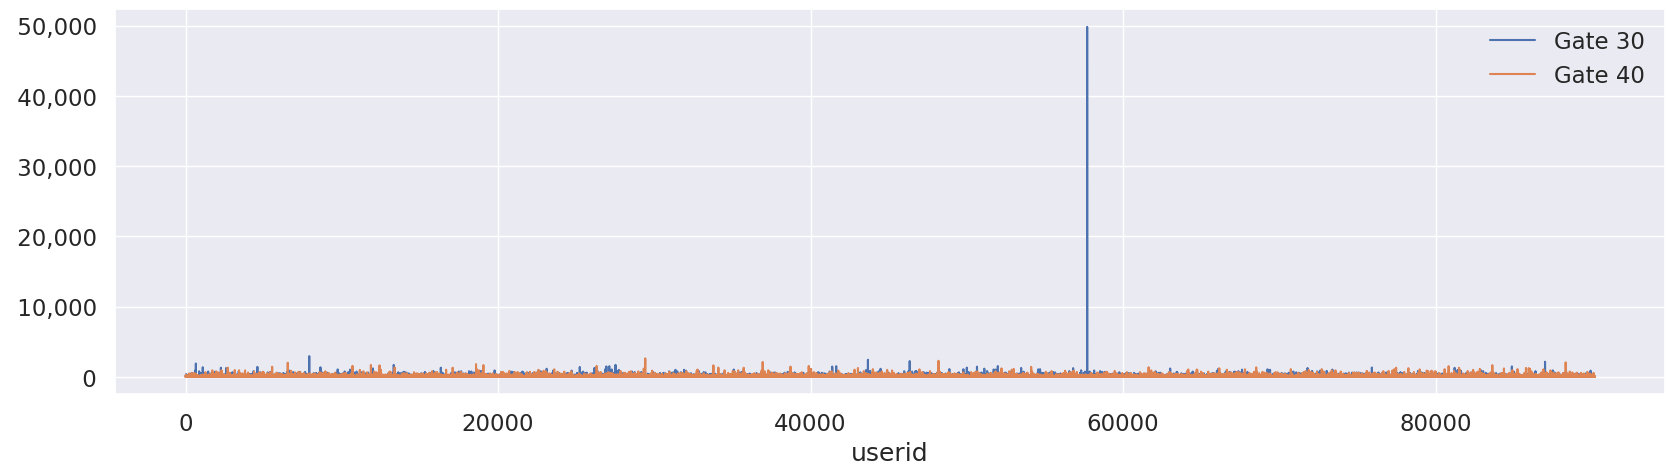

In [14]:
ax = df_30['max_gameround'].plot(legend = True, label = "Gate 30", figsize = (20,5))
ax = df_40['max_gameround'].plot(legend = True, label = "Gate 40", figsize = (20,5))

print('gamerounds - Before Removing The Extreme Value')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
plt.xlabel('userid'); 

# userid = 50000~ 60000 부근에 outlier가 존재함을 확인 

In [15]:
df_base[df_base['max_gameround'] > 30_000] # outlier 

,userid,version,max_gameround,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [16]:
len(df_30)

44700

In [17]:
# outlier 제거 
df_base = df_base[df_base['max_gameround'] < 30_000]

# gate에 따라 그룹 나누기 
df_30 = df_base[ df_base['version'] == 'gate_30' ]
df_40 = df_base[ df_base['version'] == 'gate_40' ]

len(df_30)

44699

## 2.2 Outlier 제거 후 

gamerounds - Before Removing The Extreme Value


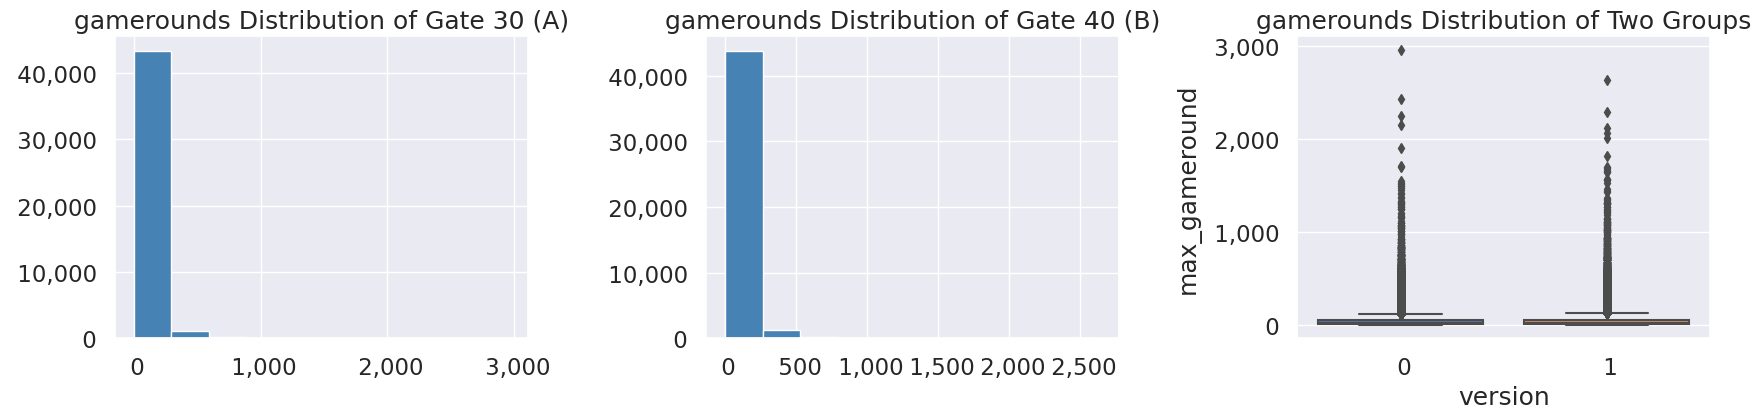

In [18]:
f, ax = plt.subplots(1, 3, figsize = (18,5))

df_30.hist("max_gameround", ax = ax[0], color = "steelblue")
df_40.hist("max_gameround", ax = ax[1], color = "steelblue")
sns.boxplot(x = df_base.version, y = df_base.max_gameround, ax = ax[2])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 


ax[0].set_title("gamerounds Distribution of Gate 30 (A)")
ax[1].set_title("gamerounds Distribution of Gate 40 (B)")
ax[2].set_title("gamerounds Distribution of Two Groups")

print("gamerounds - Before Removing The Extreme Value")
plt.tight_layout(pad = 2);

gamerounds - Before Removing The Extreme Value


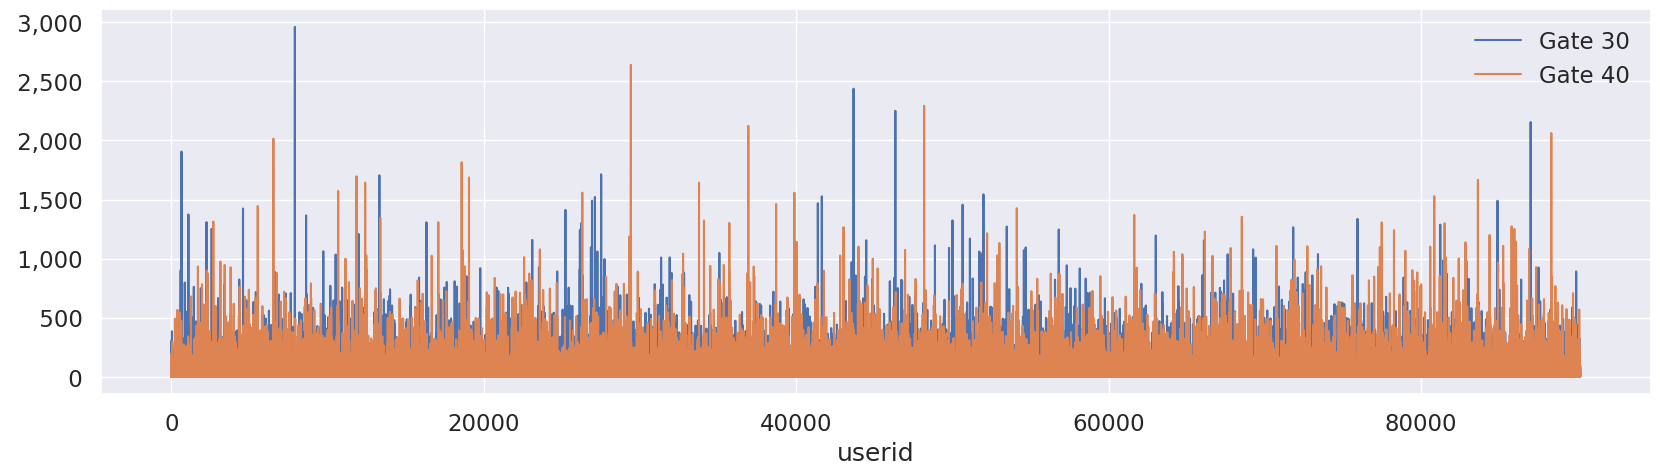

In [19]:
ax = df_30['max_gameround'].plot(legend = True, label = "Gate 30", figsize = (20,5))
ax = df_40['max_gameround'].plot(legend = True, label = "Gate 40", figsize = (20,5))

print('gamerounds - Before Removing The Extreme Value')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
plt.xlabel('userid'); 

# userid = 50000~ 60000 부근에 outlier가 존재함을 확인 

## 2.3 특이사항(detail) 확인 
- 각 그룹의 유저가 광고가 뜨는 레벨까지 플레이했는지 확인 

In [20]:
len(df_base[df_base['max_gameround'] == 0]) # 게임을 설치했으나 플레이하지 않은 유저들 

3994

In [21]:
df_base[df_base['max_gameround'] == 0].head()

,userid,version,max_gameround,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False


In [22]:
df_base[['userid', 'retention_1']].groupby('retention_1').agg({'userid':'count'}).reset_index()

,retention_1,userid
0,False,50035
1,True,40153


In [23]:
df_base[['userid', 'retention_7']].groupby('retention_7').agg({'userid':'count'}).reset_index()

,retention_7,userid
0,False,73408
1,True,16780


In [24]:
df_base[['userid', 'max_gameround']].groupby(['max_gameround'], as_index=True).agg({'userid': 'count'}) # max_gameround가 커질수록 user count 수는 줄어듦 

,userid
max_gameround,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2251,1
2294,1
2438,1


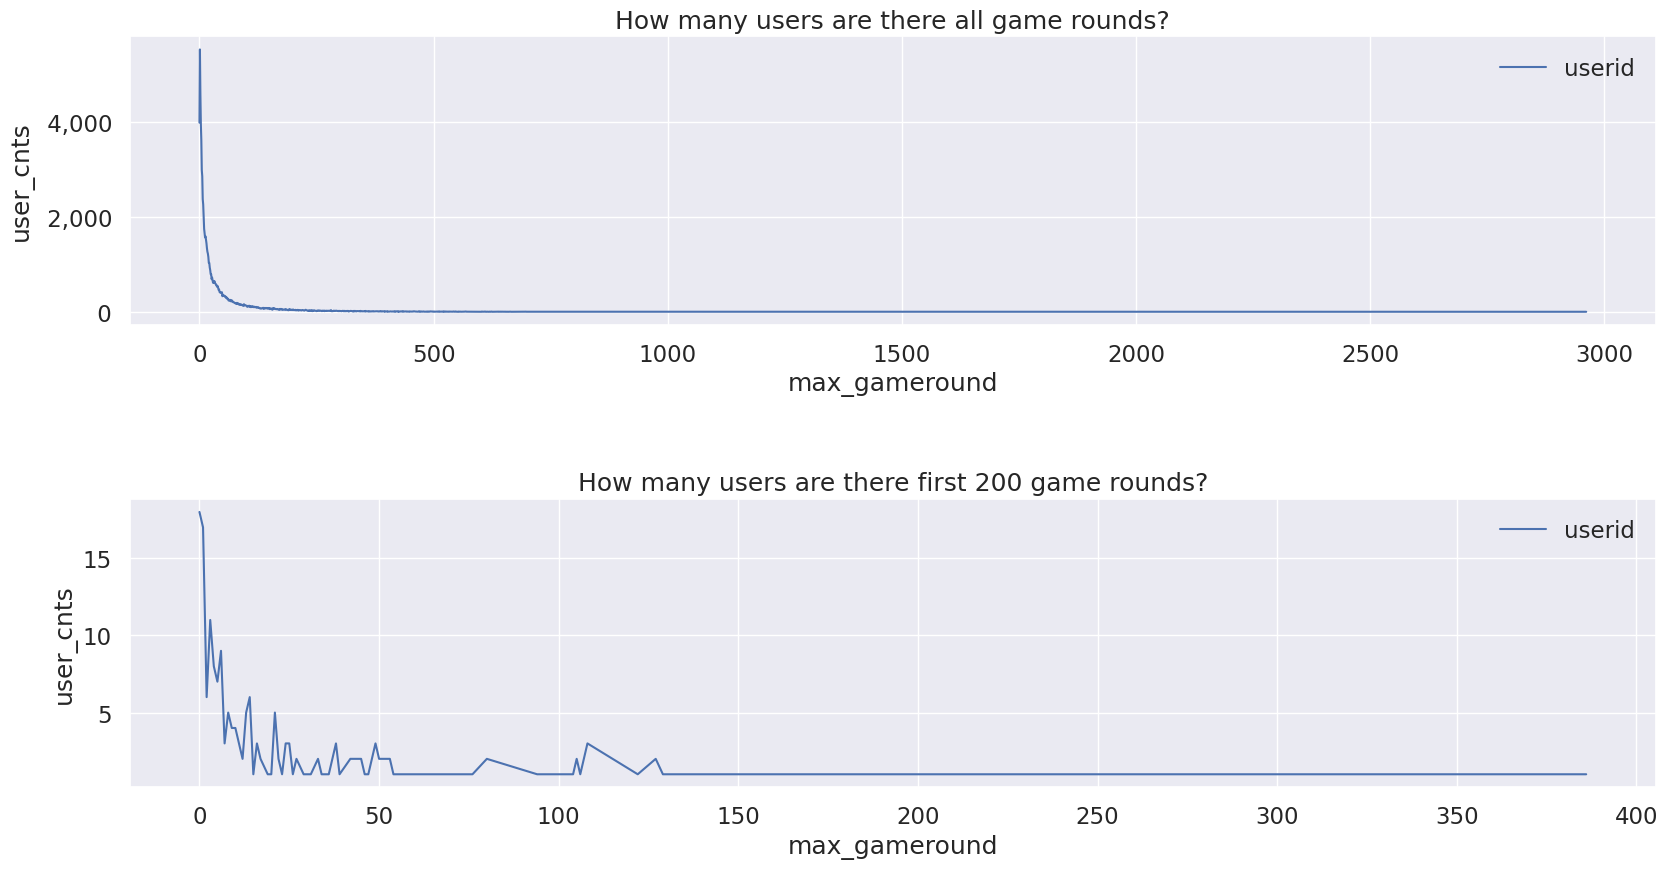

In [25]:
f, ax = plt.subplots(2, 1, figsize = (18, 10))

df_base[['userid', 'max_gameround']].groupby(['max_gameround'], as_index=True).agg(userid = ('userid', 'count')).plot(ax = ax[0])
df_base[['userid', 'max_gameround']][:200].groupby(['max_gameround'], as_index=True).agg(userid = ('userid', 'count')).plot(ax = ax[1])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

ax[0].set_title("How many users are there all game rounds?")
ax[1].set_title("How many users are there first 200 game rounds?")

ax[0].set_ylabel('user_cnts')
ax[1].set_ylabel('user_cnts')
plt.tight_layout(pad=3);


- gate_30: level = 30에 도달 시 광고창 뜸 
- gate_40: level = 40에 도달 시 광고창 뜸 

**즉, 각 유저가 해당 level의 gameround까지 플레이했는지 확인해야 함!!**

In [26]:
# A group 
print(len(df_30[df_30['max_gameround'] >= 30]))
print(len(df_30[df_30['max_gameround'] < 30]))

df_30['over_level'] = df_30.apply(lambda x: True if x.max_gameround >= 30 else False, axis = 1)
df_30.head()

16655
28044


,userid,version,max_gameround,retention_1,retention_7,over_level
0,116,gate_30,3,False,False,False
1,337,gate_30,38,True,False,True
6,1066,gate_30,0,False,False,False
11,2101,gate_30,0,False,False,False
13,2179,gate_30,39,True,False,True


In [27]:
# B group 
print(len(df_40[df_40['max_gameround'] >= 40]))
print(len(df_40[df_40['max_gameround'] < 40]))

df_40['over_level'] = df_40.apply(lambda x: True if x.max_gameround >= 40 else False, axis = 1)
df_40.head()

13827
31662


,userid,version,max_gameround,retention_1,retention_7,over_level
2,377,gate_40,165,True,False,True
3,483,gate_40,1,False,False,False
4,488,gate_40,179,True,True,True
5,540,gate_40,187,True,True,True
7,1444,gate_40,2,False,False,False


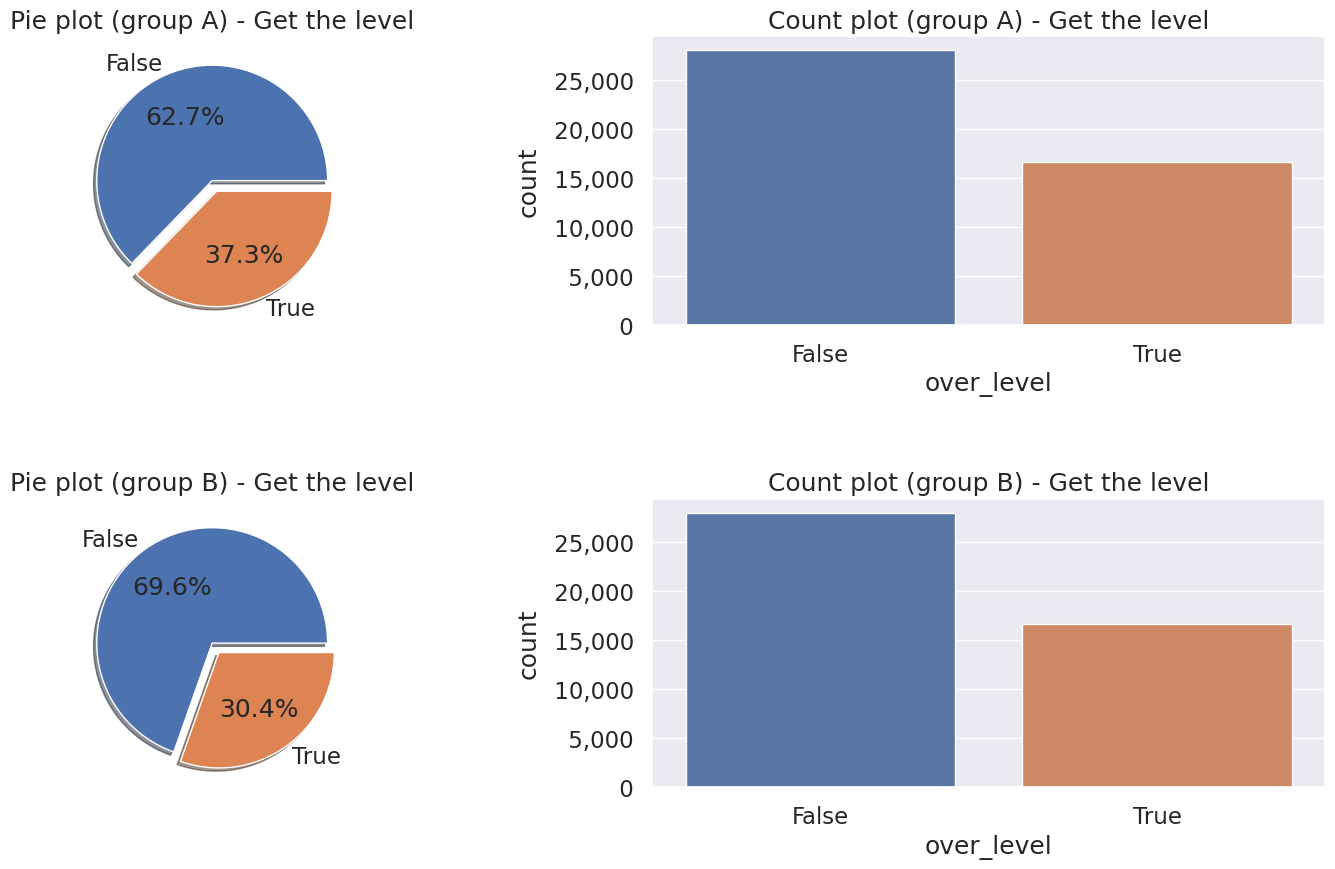

In [28]:
# plotting pie chart 
f, ax = plt.subplots(2, 2, figsize = (16, 10))

df_30['over_level'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0][0], shadow = True)
sns.countplot(x = df_30['over_level'], ax = ax[0][1])

df_40['over_level'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[1][0], shadow = True )
sns.countplot(x = df_30['over_level'], ax = ax[1][1])

# subplot - group 1 
ax[0][0].set_title('Pie plot (group A) - Get the level')
ax[0][0].set_ylabel('')
ax[0][1].set_title('Count plot (group A) - Get the level')
ax[0][1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

# subplot - group 2 
ax[1][0].set_title('Pie plot (group B) - Get the level')
ax[1][0].set_ylabel('')
ax[1][1].set_title('Count plot (group B) - Get the level')
ax[1][1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

plt.tight_layout(pad=3);

- group A 와 group B의 분포는 어느 정도 비슷해보임 
  - 해당 level에 도달했는지 vs. 안했는지 

#_3. A/B Testing 

가설: level = 40일 때 유료 결제를 유도하는 창을 띄우는 것이 level = 30일 때 띄우는 것보다 전환율이 높다. 

- A그룹: gate_30, B그룹: gate_40

In [32]:
df_all = pd.concat([df_30, df_40])


In [34]:
df_all['group'] = np.where(df_all.version == 'gate_30', 'A', 'B')
df_all.head()

,userid,version,max_gameround,retention_1,retention_7,over_level,group
0,116,gate_30,3,False,False,False,A
1,337,gate_30,38,True,False,True,A
6,1066,gate_30,0,False,False,False,A
11,2101,gate_30,0,False,False,False,A
13,2179,gate_30,39,True,False,True,A


In [35]:
# Packages
from scipy.stats import shapiro
import scipy.stats as stats

In [ ]:
# A/B test Assumptions 

# 1) Normality  : Shapiro Test 
# 2) Homogenity : Levene Test 

# If Parametric + homogenity -> T-Test 
# If Parametric - homogenity -> Welch Test 
# If Non-parametric -> Mann Whitney U Test 


참고: 
- Non-parametric vs Parametric: https://www.youtube.com/watch?v=ftnOBcXtBEQ 
